In [38]:
# You can install packages in a Jupyter Notebook cell using pip with the ! prefix.
# For example, to install numpy, pandas, matplotlib, seaborn, and scikit-learn, run:

!pip install numpy pandas matplotlib seaborn scikit-learn wfdb

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import ast

In [15]:
# First try: let pandas guess the delimiter
df = pd.read_csv(r'C:\Users\Kimia\thesis related\thesis_coding\test\ptbxl_database.csv',header=0, index_col=0)

print(df.shape)
df.head()

(21799, 27)


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [16]:
import pandas as pd
import ast

# Convert the scp_codes column from string to dictionary
#df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
if isinstance(df['scp_codes'].iloc[0], str):
    df['scp_codes'] = df['scp_codes'].apply(lambda x: ast.literal_eval(x))

# Count AFIB
afib_count = df['scp_codes'].apply(lambda x: 'AFIB' in x).sum()
sr_count = df['scp_codes'].apply(lambda x: 'SR' in x).sum()


# Print results
print(f'Normal (SR) has a total of {sr_count} rows')
print(f'Atrial Fibrillation (AFIB) has a total of {afib_count} rows')

Normal (SR) has a total of 16748 rows
Atrial Fibrillation (AFIB) has a total of 1514 rows


In [17]:
# Safe parsing: convert string to dictionary if needed
df['scp_codes'] = df['scp_codes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract and sort all unique SCP labels
all_labels = set()
df['scp_codes'].apply(lambda x: all_labels.update(x.keys()))
sorted_labels = sorted(all_labels)

# Count rows where each label appears
label_counts = {}
for label in sorted_labels:
    label_counts[label] = df['scp_codes'].apply(lambda x: label in x).sum()

# Display the counts
print("Counts of each SCP code label in the dataset:")
for label, count in label_counts.items():
    print(f"- {label}: {count} rows")

Counts of each SCP code label in the dataset:
- 1AVB: 793 rows
- 2AVB: 14 rows
- 3AVB: 16 rows
- ABQRS: 3327 rows
- AFIB: 1514 rows
- AFLT: 73 rows
- ALMI: 288 rows
- AMI: 353 rows
- ANEUR: 104 rows
- ASMI: 2357 rows
- BIGU: 82 rows
- CLBBB: 536 rows
- CRBBB: 541 rows
- DIG: 181 rows
- EL: 96 rows
- HVOLT: 62 rows
- ILBBB: 77 rows
- ILMI: 478 rows
- IMI: 2676 rows
- INJAL: 145 rows
- INJAS: 214 rows
- INJIL: 15 rows
- INJIN: 18 rows
- INJLA: 17 rows
- INVT: 294 rows
- IPLMI: 51 rows
- IPMI: 33 rows
- IRBBB: 1118 rows
- ISCAL: 659 rows
- ISCAN: 44 rows
- ISCAS: 169 rows
- ISCIL: 179 rows
- ISCIN: 218 rows
- ISCLA: 140 rows
- ISC_: 1272 rows
- IVCD: 787 rows
- LAFB: 1623 rows
- LAO/LAE: 426 rows
- LMI: 201 rows
- LNGQT: 117 rows
- LOWT: 438 rows
- LPFB: 177 rows
- LPR: 340 rows
- LVH: 2132 rows
- LVOLT: 182 rows
- NDT: 1825 rows
- NORM: 9514 rows
- NST_: 767 rows
- NT_: 423 rows
- PAC: 398 rows
- PACE: 294 rows
- PMI: 17 rows
- PRC(S): 10 rows
- PSVT: 24 rows
- PVC: 1143 rows
- QWAVE: 54

In [21]:
import ast

# Step 1: Make a copy of the DataFrame
afib_df = df.copy()

# Step 2: Ensure 'scp_codes' are dictionaries (safe conversion)
afib_df['scp_codes'] = afib_df['scp_codes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 3: Create 'ritmi' column
def classify_ritmi(scp):
    if 'AFIB' in scp:
        return 'AF'
    elif 'SR' in scp:
        return 'SR'
    elif any(code in scp for code in ['PVC', 'VFL', 'VT', 'PAC']):  # common VA indicators
        return 'VA'
    else:
        return 'Unknown'

afib_df['ritmi'] = afib_df['scp_codes'].apply(classify_ritmi)

# Step 4: Drop unnecessary columns (only if they exist)
columns_to_drop = [
    'ecg_id', 'patient_id', 'nurse', 'site', 'device', 'report', 'scp_codes',
    'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion',
    'initial_autogenerated_report', 'baseline_drift', 'static_noise', 'burst_noise',
    'electrodes_problems', 'extra_beats', 'pacemaker', 'filename_lr', 'filename_hr'
]
afib_df = afib_df.drop(columns=[col for col in columns_to_drop if col in afib_df.columns])

# Step 5: Convert 'ritmi' to numeric codes
num_di = {'SR': 0, 'AF': 1, 'VA': 2, 'Unknown': -1}
afib_df['ritmi'] = afib_df['ritmi'].replace(num_di)

# Step 6: Convert validated_by_human to 0/1 if present
if 'validated_by_human' in afib_df.columns:
    bool_di = {False: 0, True: 1}
    afib_df['validated_by_human'] = afib_df['validated_by_human'].replace(bool_di)

# (Optional) Show the counts for each class
print(afib_df['ritmi'].value_counts())


ritmi
 0    16748
-1     3137
 1     1514
 2      400
Name: count, dtype: int64


C:\Users\Kimia\AppData\Local\Temp\ipykernel_19872\4050102293.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  afib_df['ritmi'] = afib_df['ritmi'].replace(num_di)
C:\Users\Kimia\AppData\Local\Temp\ipykernel_19872\4050102293.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  afib_df['validated_by_human'] = afib_df['validated_by_human'].replace(bool_di)


In [23]:
# Ensure 'afib_df' exists and is copied from 'df'
afib_df = df.copy()

# Define age group function
def get_age_group(age):
    if pd.isnull(age):
        return 'Missing'
    elif 0 <= age <= 9:
        return '0-9 Years'
    elif 10 <= age <= 19:
        return '10-19 Years'
    elif 20 <= age <= 29:
        return '20-29 Years'
    elif 30 <= age <= 39:
        return '30-39 Years'
    elif 40 <= age <= 49:
        return '40-49 Years'
    elif 50 <= age <= 59:
        return '50-59 Years'
    elif 60 <= age <= 69:
        return '60-69 Years'
    elif 70 <= age <= 79:
        return '70-79 Years'
    elif age >= 80:
        return '80+ Years'
    else:
        return 'Unknown'

# Apply age grouping
afib_df['age_group'] = afib_df['age'].apply(get_age_group)

# (Optional) Check the age group distribution
print(afib_df['age_group'].value_counts())


age_group
60-69 Years    5248
50-59 Years    4441
70-79 Years    4093
80+ Years      2708
40-49 Years    2462
30-39 Years    1468
20-29 Years     898
10-19 Years     467
0-9 Years        14
Name: count, dtype: int64


In [26]:
# Define a function to group height
def get_height_group(height):
    if pd.isnull(height):
        return 'Missing'
    elif height < 150.0:
        return '<1.50m'
    elif 150.0 <= height <= 159.9:
        return '1.50–1.59m'
    elif 160.0 <= height <= 169.9:
        return '1.60–1.69m'
    elif 170.0 <= height <= 179.9:
        return '1.70–1.79m'
    elif 180.0 <= height <= 189.9:
        return '1.80–1.89m'
    elif 190.0 <= height <= 199.9:
        return '1.90–1.99m'
    elif height >= 200.0:
        return '2.00m+'
    else:
        return 'Unknown'

# Apply the function to create a new column
afib_df['height_group'] = afib_df['height'].apply(get_height_group)

# Optional: check distribution
print(afib_df['height_group'].value_counts())


height_group
Missing       14825
1.60–1.69m     2618
1.70–1.79m     1985
1.50–1.59m     1451
1.80–1.89m      754
<1.50m           97
1.90–1.99m       67
2.00m+            2
Name: count, dtype: int64


In [27]:
# Define a function to group weight
def get_weight_group(weight):
    if pd.isnull(weight):
        return 'Missing'
    elif weight < 60.0:
        return '<60kg'
    elif 60.0 <= weight <= 69.9:
        return '60–69kg'
    elif 70.0 <= weight <= 79.9:
        return '70–79kg'
    elif 80.0 <= weight <= 89.9:
        return '80–89kg'
    elif 90.0 <= weight <= 99.9:
        return '90–99kg'
    elif weight >= 100.0:
        return '100kg+'
    else:
        return 'Unknown'

# Apply the function to create a new column
afib_df['weight_group'] = afib_df['weight'].apply(get_weight_group)

# Optional: check group distribution
print(afib_df['weight_group'].value_counts())


weight_group
Missing    12378
70–79kg     2360
60–69kg     2342
<60kg       2144
80–89kg     1531
90–99kg      689
100kg+       355
Name: count, dtype: int64


In [29]:
import ast

# Convert string to dictionary if needed
afib_df['scp_codes'] = afib_df['scp_codes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Create the 'ritmi' column based on scp_codes
def classify_ritmi(scp):
    if 'AFIB' in scp:
        return 1  # AF
    elif 'SR' in scp:
        return 0  # SR
    elif any(code in scp for code in ['PVC', 'VFL', 'VT', 'PAC']):
        return 2  # VA
    else:
        return -1  # Unknown

afib_df['ritmi'] = afib_df['scp_codes'].apply(classify_ritmi)


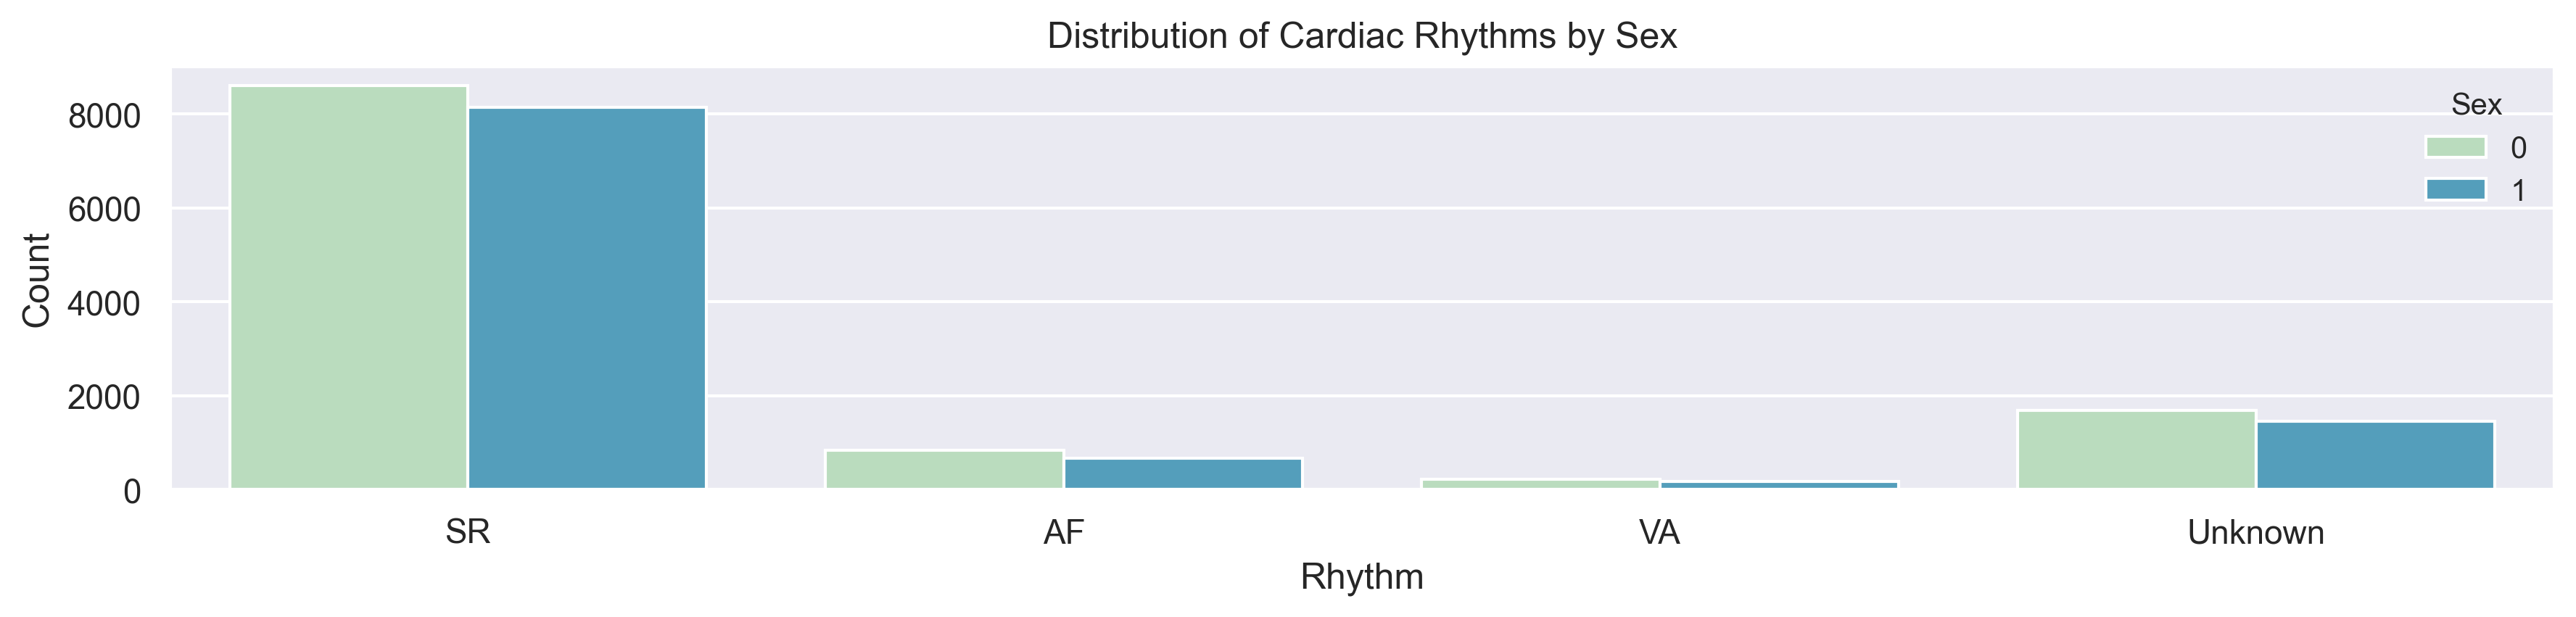

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure style and resolution
sns.set(rc={'figure.figsize': (12, 3)})
plt.rcParams['figure.dpi'] = 300

# Map numeric labels to text
ritmi_map = {0: 'SR', 1: 'AF', 2: 'VA', -1: 'Unknown'}
afib_df['ritmi_label'] = afib_df['ritmi'].map(ritmi_map)

# Plot
sns.countplot(
    x='ritmi_label',
    data=afib_df,
    hue='sex',
    order=['SR', 'AF', 'VA', 'Unknown'],
    palette='GnBu'
)

plt.xlabel('Rhythm')
plt.ylabel('Count')
plt.title('Distribution of Cardiac Rhythms by Sex')
plt.legend(title='Sex', fontsize='small', title_fontsize='small', framealpha=0)
plt.tight_layout()
plt.show()


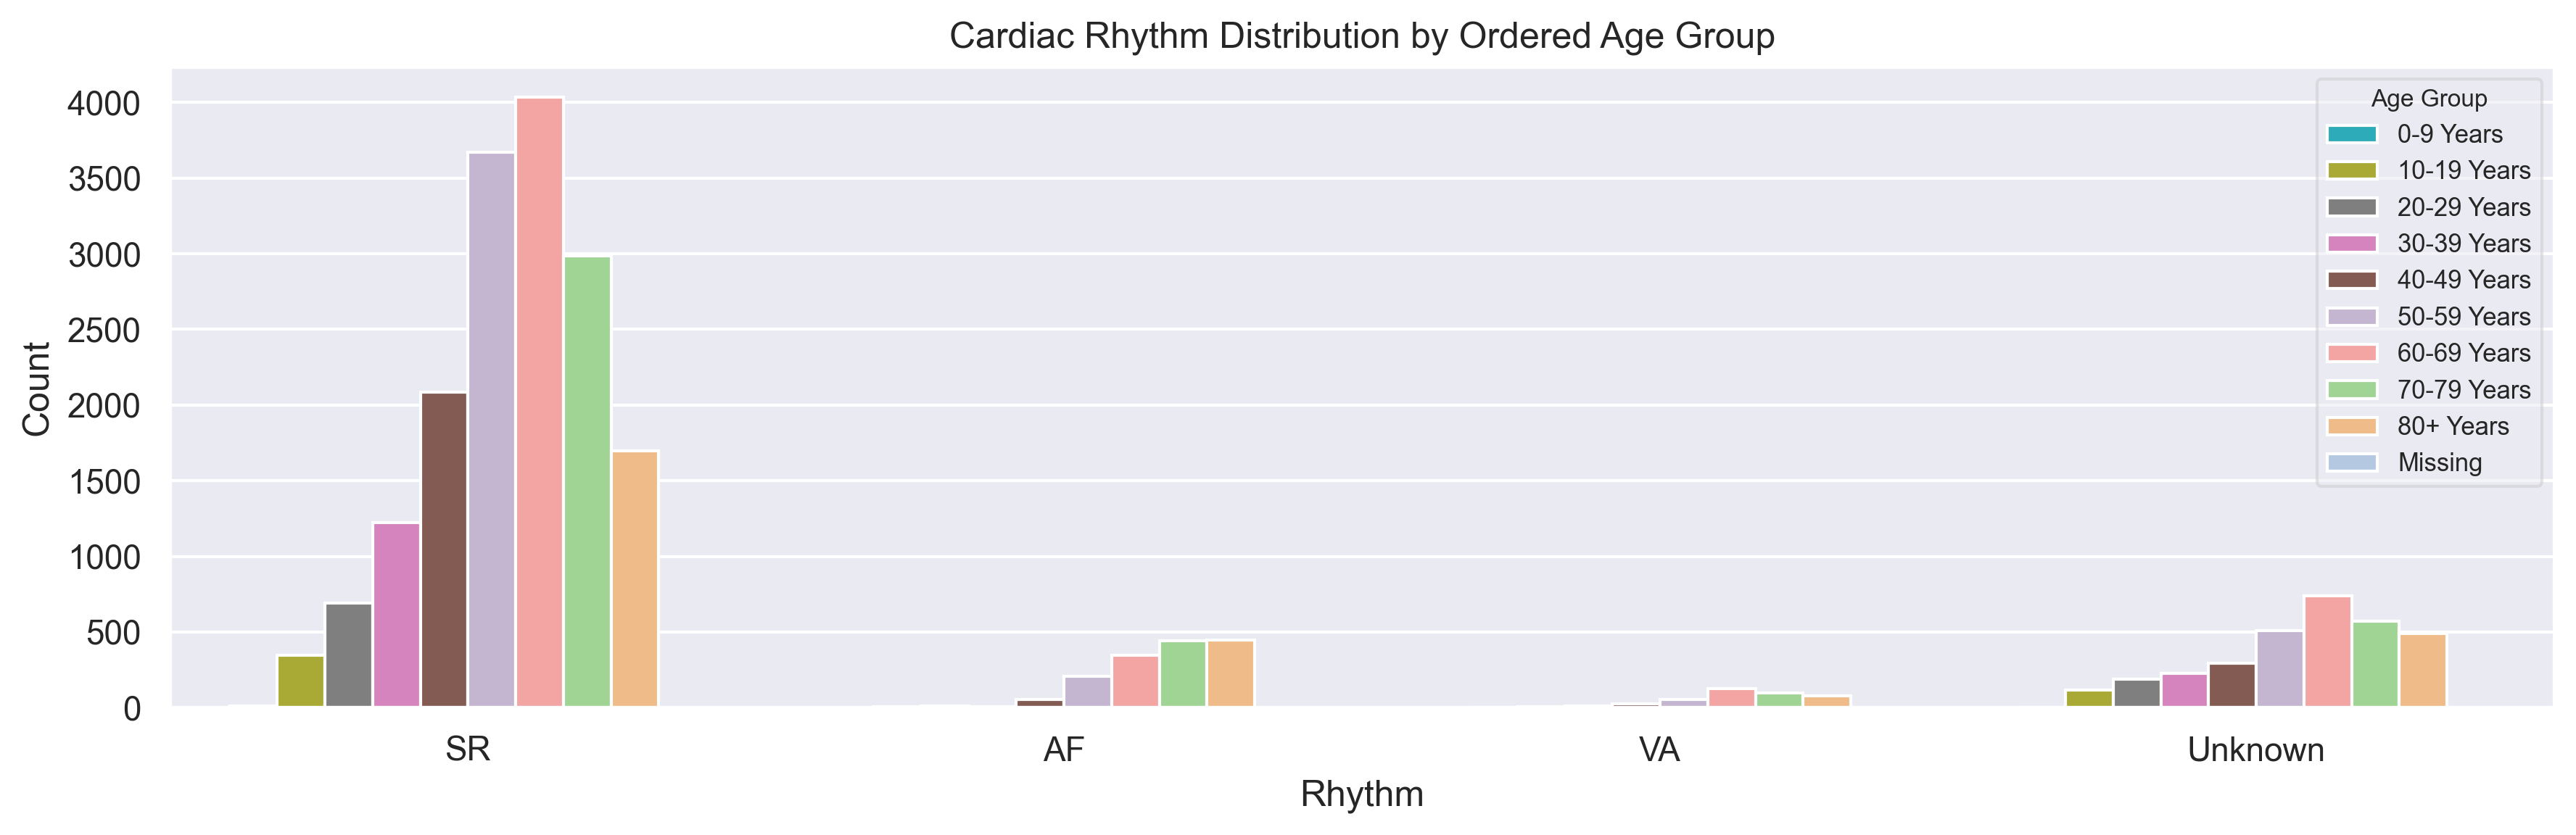

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define the desired age group order
age_order = [
    '0-9 Years', '10-19 Years', '20-29 Years', '30-39 Years',
    '40-49 Years', '50-59 Years', '60-69 Years', '70-79 Years', '80+ Years', 'Missing'
]

# 2. Convert age_group to ordered categorical
afib_df['age_group'] = pd.Categorical(afib_df['age_group'], categories=age_order, ordered=True)

# 3. Map ritmi numeric to labels for plotting
ritmi_map = {0: 'SR', 1: 'AF', 2: 'VA', -1: 'Unknown'}
afib_df['ritmi_label'] = afib_df['ritmi'].map(ritmi_map)

# 4. Set up plot style
sns.set(rc={'figure.figsize': (12, 4)})
plt.rcParams['figure.dpi'] = 300

# 5. Create countplot with properly ordered age_group
sns.countplot(
    x='ritmi_label',
    data=afib_df,
    hue='age_group',
    order=['SR', 'AF', 'VA', 'Unknown'],
    palette='tab20_r'
)

# 6. Formatting
plt.xlabel('Rhythm')
plt.ylabel('Count')
plt.title('Cardiac Rhythm Distribution by Ordered Age Group')
plt.legend(title='Age Group', fontsize='x-small', title_fontsize='8', framealpha=0.5, loc='best')
plt.tight_layout()
plt.show()


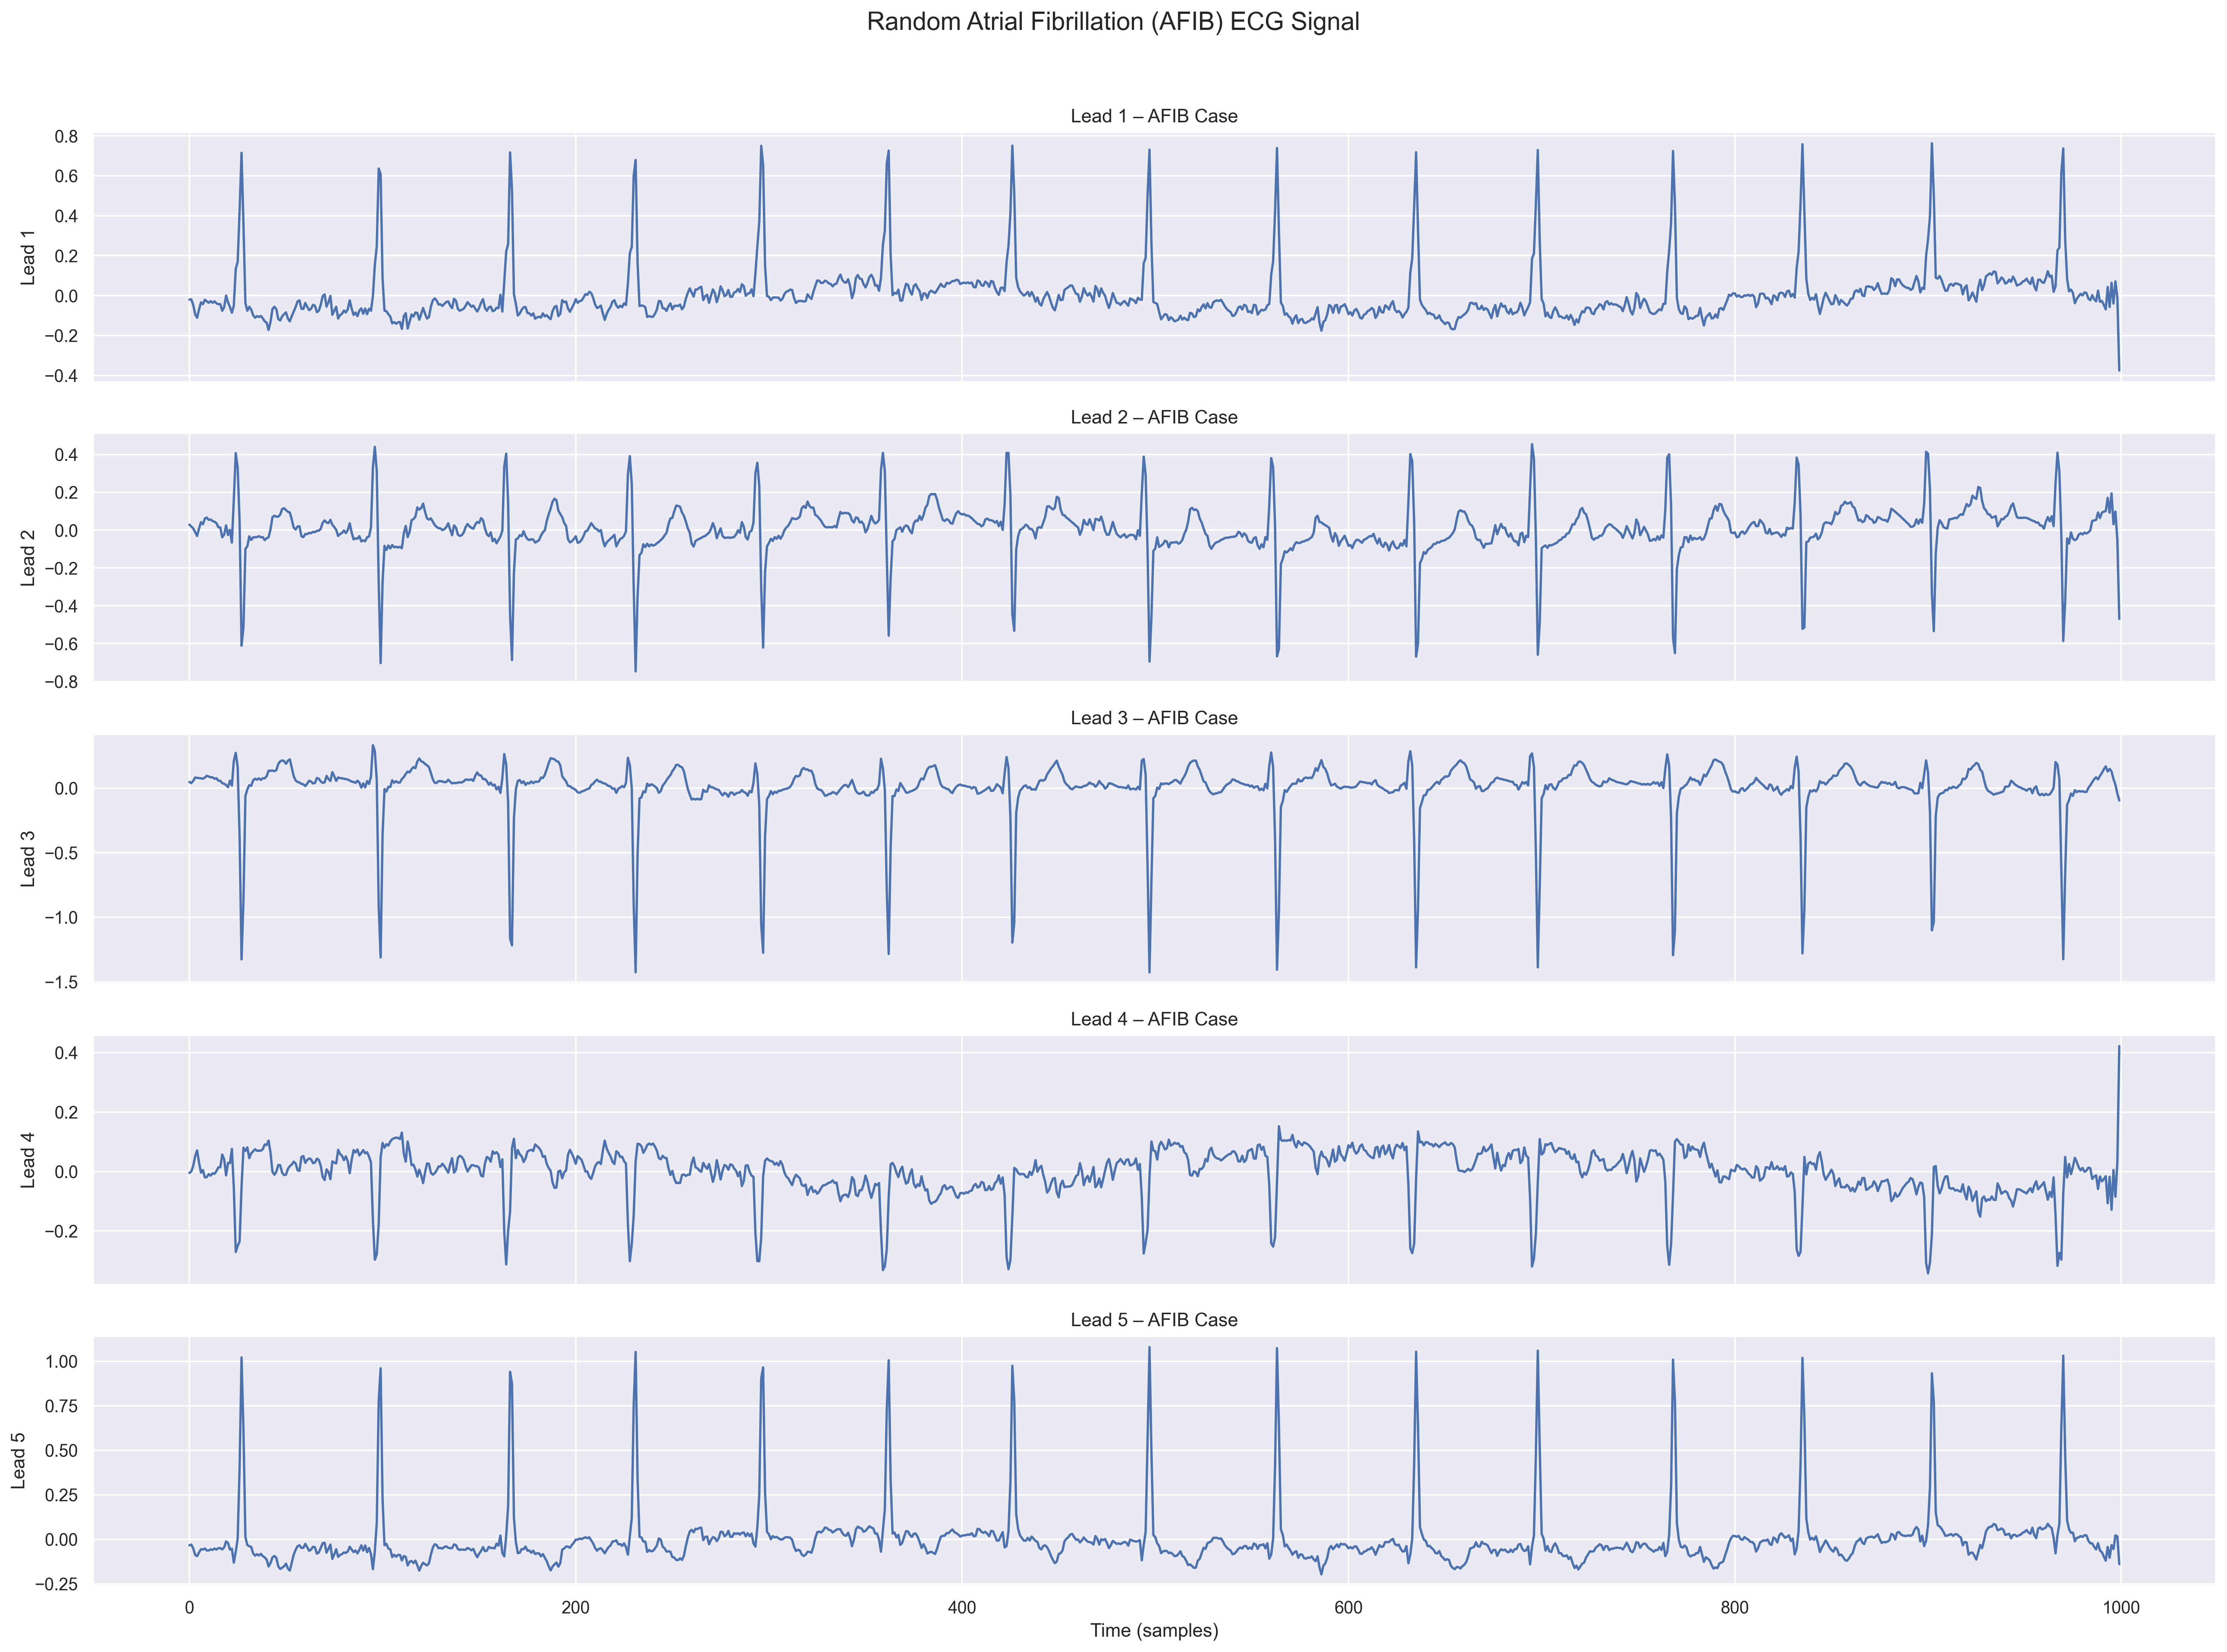

In [43]:
import wfdb
import matplotlib.pyplot as plt

# Pick a random AFIB case
afib_sample = afib_df[afib_df['ritmi'] == 1].sample(1)
afib_idx = afib_sample.index[0]
record_path = afib_sample['filename_lr'].values[0]

# Fix the full path by adding 'ptb-xl'
base_path = f"C:/Users/Kimia/thesis related/thesis_coding/test/ptb-xl/{record_path}"

# Load the ECG signal
record = wfdb.rdrecord(base_path)
signal = record.p_signal

# Plot first 5 leads
fig, ax = plt.subplots(5, 1, figsize=(20, 15), sharex=True)
for i in range(5):
    ax[i].plot(signal[:, i])
    ax[i].set_ylabel(f'Lead {i+1}')
    ax[i].set_title(f'Lead {i+1} – AFIB Case')

plt.xlabel('Time (samples)')
plt.suptitle('Random Atrial Fibrillation (AFIB) ECG Signal', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


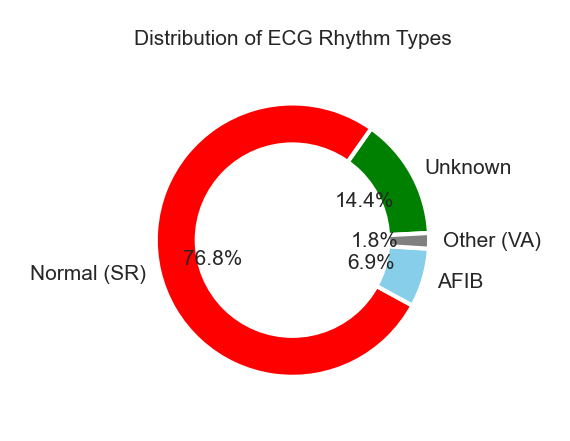

In [64]:
import matplotlib.pyplot as plt

# 1. Count class distribution from 'ritmi'
class_counts = afib_df['ritmi'].value_counts().sort_index()
labels_map = {0: 'Normal (SR)', 1: 'AFIB', 2: 'Other (VA)', -1: 'Unknown'}
colors = ['green', 'red', 'skyblue', 'gray']

# 2. Prepare labels and values
labels = [labels_map[i] for i in class_counts.index]
sizes = class_counts.values

# 3. Plot donut pie chart
plt.figure(figsize=(2, 2))
my_circle = plt.Circle((0, 0), 0.70, color='white')
plt.pie(
    sizes,
    labels=labels,
    colors=colors[:len(sizes)],
    autopct='%1.1f%%',
    startangle=3,
    textprops={'fontsize': 5}
)
plt.gca().add_artist(my_circle)
plt.title('Distribution of ECG Rhythm Types', fontsize=5)
plt.tight_layout()
plt.show()
